In [1]:
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    # specify the path of the folder containing "file_name" :
    path_to_file = '/content/gdrive/My Drive/5153: Applied Machine Learning/LSTM Data/'
    print(path_to_file)
    # change current path to the folder containing "file_name"
    os.chdir(path_to_file)
    !pwd

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/5153: Applied Machine Learning/LSTM Data/
/content/gdrive/My Drive/5153: Applied Machine Learning/LSTM Data


In [2]:
import pandas as pd
import numpy as np
import datetime
from datetime import date, timedelta
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
tf.random.set_seed(221)

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model
import math
import prediction_prep as prep

import warnings
warnings.filterwarnings('ignore')

## Load in Data

In [3]:
# READ IN ALL DATA
ticker = 'AMZN'
comments = pd.read_csv('comments_preprocessed_assigned.csv')
sentiment = pd.read_csv('df_pred_id_body.csv')
# fin_data = pd.read_csv(r'C:\Users\Nylle\`Assignments\LSTM\Stock\AMZN_2021.csv')
fin_data = pd.read_csv('stock_data/{}_2021.csv'.format(ticker))

# Call custom function to get concatenated df with all features
df = prep.get_regression_df(ticker_name = str.lower(ticker),
                           comments = comments, 
                           fin_data = fin_data,
                           sentiment = sentiment)

# Set up a results dictionary object
results_dict = {}

df.head()

,date,comments_neutral,comments_positive,comment_count,pct_pos_comments,is_meme,comments_neutral_rollsum_2D,comments_neutral_rollmean_2D,comments_neutral_2D_pctchg,comments_positive_rollsum_2D,...,Dir,2Dir,3Dir,4Dir,5Dir,6Dir,7Dir,SD,day_of_week,SD_log
0,2021-01-01,0.0,0.0,0.0,0.000000,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN
1,2021-01-02,1.0,0.0,1.0,0.000000,0,1.0,0.5,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN
2,2021-01-03,1.0,0.0,1.0,0.000000,0,2.0,1.0,100.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,NaN
3,2021-01-04,2.0,1.0,3.0,33.332222,0,3.0,1.5,100.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.704330,0,-0.350508
4,2021-01-05,2.0,0.0,2.0,0.000000,0,4.0,2.0,100.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.357044,1,-1.029896


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366 entries, 0 to 365
Data columns (total 100 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   date                           366 non-null    datetime64[ns]
 1   comments_neutral               366 non-null    float64       
 2   comments_positive              366 non-null    float64       
 3   comment_count                  366 non-null    float64       
 4   pct_pos_comments               366 non-null    float64       
 5   is_meme                        366 non-null    int64         
 6   comments_neutral_rollsum_2D    365 non-null    float64       
 7   comments_neutral_rollmean_2D   365 non-null    float64       
 8   comments_neutral_2D_pctchg     319 non-null    float64       
 9   comments_positive_rollsum_2D   365 non-null    float64       
 10  comments_positive_rollmean_2D  365 non-null    float64       
 11  comments_positive_

## LSTM: CLOSE PRICE WITH SENTIMENT

### 1-Day Shift

In [5]:
## DAILY%CHANGE ##
dep_var = ['Close'] 
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 1

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)

pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['High', 'Low', '3Dir', '4D%Change', '6D%Change', 'Open', '7D%Change', 'SD', 'SD_log', 'Volume', '6Dir', 'Dir', '4Dir', '5D%Change', '7Dir', '2D%Change', '5Dir', '2Dir', 'Daily%Change', '3D%Change']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Close,day_of_week,comments_neutral(t-1),comments_positive(t-1),comment_count(t-1),pct_pos_comments(t-1),comments_neutral_rollsum_2D(t-1),comments_neutral_rollmean_2D(t-1),comments_neutral_2D_pctchg(t-1),comments_positive_rollsum_2D(t-1),...,Dir(t-1),4Dir(t-1),5D%Change(t-1),7Dir(t-1),2D%Change(t-1),5Dir(t-1),2Dir(t-1),Daily%Change(t-1),3D%Change(t-1),Close(t-1)
7,3165.889893,2,3.0,2.0,5.0,39.999200,7.0,3.5,-72.727273,4.0,...,1.0,0.0,-3.034943,0.0,-1.943943,0.0,0.0,0.212578,-1.307013,3120.830078
9,3104.250000,4,3.0,5.0,8.0,62.499219,6.0,3.0,0.000000,5.0,...,0.0,0.0,-1.097033,0.0,0.212760,0.0,1.0,-1.213558,0.425790,3127.469971
10,3120.760010,1,3.0,1.0,4.0,24.999375,5.0,2.5,-57.142857,3.0,...,0.0,0.0,-2.464887,0.0,-1.947001,0.0,0.0,-0.742452,-0.531271,3104.250000
11,3263.379883,2,5.0,5.0,10.0,49.999500,8.0,4.0,150.000000,6.0,...,1.0,0.0,0.210328,0.0,-0.214549,1.0,0.0,0.531852,-1.425504,3120.760010
12,3306.989990,3,114.0,17.0,131.0,12.977089,119.0,59.5,3700.000000,22.0,...,1.0,1.0,4.567689,1.0,5.126194,1.0,1.0,4.570037,4.345682,3263.379883


In [6]:
# List of considered Features
FEATURES = pred_lag.columns

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext[dep_var[0]]

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['Close', 'day_of_week', 'comments_neutral(t-1)', 'comments_positive(t-1)', 'comment_count(t-1)', 'pct_pos_comments(t-1)', 'comments_neutral_rollsum_2D(t-1)', 'comments_neutral_rollmean_2D(t-1)', 'comments_neutral_2D_pctchg(t-1)', 'comments_positive_rollsum_2D(t-1)', 'comments_positive_rollmean_2D(t-1)', 'comments_positive_2D_pctchg(t-1)', 'comment_count_rollsum_2D(t-1)', 'comment_count_rollmean_2D(t-1)', 'comment_count_2D_pctchg(t-1)', 'pct_pos_comments_rollsum_2D(t-1)', 'pct_pos_comments_rollmean_2D(t-1)', 'pct_pos_comments_2D_pctchg(t-1)', 'comments_neutral_rollsum_3D(t-1)', 'comments_neutral_rollmean_3D(t-1)', 'comments_neutral_3D_pctchg(t-1)', 'comments_positive_rollsum_3D(t-1)', 'comments_positive_rollmean_3D(t-1)', 'comments_positive_3D_pctchg(t-1)', 'comment_count_rollsum_3D(t-1)', 'comment_count_rollmean_3D(t-1)', 'comment_count_3D_pctchg(t-1)', 'pct_pos_comments_rollsum_3D(t-1)', 'pct_pos_comments_rollmean_3D(t-1)', 'pct_pos_comments_3D_pctchg(t-1)', 'comments_ne

,Close,day_of_week,comments_neutral(t-1),comments_positive(t-1),comment_count(t-1),pct_pos_comments(t-1),comments_neutral_rollsum_2D(t-1),comments_neutral_rollmean_2D(t-1),comments_neutral_2D_pctchg(t-1),comments_positive_rollsum_2D(t-1),...,4Dir(t-1),5D%Change(t-1),7Dir(t-1),2D%Change(t-1),5Dir(t-1),2Dir(t-1),Daily%Change(t-1),3D%Change(t-1),Close(t-1),Prediction
218,3525.149902,4,12.0,3.0,15.0,19.999867,16.0,8.0,100.000000,3.0,...,0.0,-0.129422,1.0,-2.900540,0.0,0.0,-0.274265,-0.472344,3472.500000,3525.149902
219,3545.679932,0,1.0,1.0,2.0,49.997500,3.0,1.5,0.000000,1.0,...,1.0,0.175048,1.0,1.237772,1.0,1.0,1.516196,-1.428322,3525.149902,3545.679932
223,3676.570068,4,2.0,1.0,3.0,33.332222,3.0,1.5,100.000000,1.0,...,1.0,6.438015,1.0,4.387836,1.0,1.0,4.143704,4.241221,3696.060059,3676.570068
226,3580.409912,2,37.0,5.0,42.0,11.904734,38.0,19.0,100.000000,5.0,...,1.0,1.111082,1.0,-2.625546,1.0,0.0,0.209092,-3.139019,3580.040039,3580.409912
227,3504.560059,4,4.0,3.0,7.0,42.856531,67.0,33.5,-89.189189,20.0,...,0.0,0.885036,1.0,0.219445,1.0,1.0,0.010332,-2.615485,3580.409912,3504.560059


In [7]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc(dep_var[0])

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data first
train_data = data_filtered.iloc[0:train_data_len]
test_data = data_filtered.iloc[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)


# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext[dep_var[0]][0:train_data_len])
np_Close_scaled = scaler_pred.fit_transform(df_Close)


(103, 100)
(32, 100)


In [8]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(96, 7, 100) (96,)
(25, 7, 100) (25,)
0.4623791344315302
0.4623791344315302


In [9]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

700 7 100


In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = '{}_{}_{}shift_Sentiment.h5'.format(ticker, dep_var[0], shift)
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
6/6 [==============================] - ETA: 0s - loss: 0.3374
Epoch 1: val_loss improved from inf to 0.13896, saving model to AMZN_Close_1shift_Sentiment.h5
6/6 [==============================] - 6s 497ms/step - loss: 0.3374 - val_loss: 0.1390
Epoch 2/100
6/6 [==============================] - ETA: 0s - loss: 0.0552
Epoch 2: val_loss improved from 0.13896 to 0.03630, saving model to AMZN_Close_1shift_Sentiment.h5
6/6 [==============================] - 2s 317ms/step - loss: 0.0552 - val_loss: 0.0363
Epoch 3/100
6/6 [==============================] - ETA: 0s - loss: 0.0328
Epoch 3: val_loss improved from 0.03630 to 0.02688, saving model to AMZN_Close_1shift_Sentiment.h5
6/6 [==============================] - 2s 318ms/step - loss: 0.0328 - val_loss: 0.0269
Epoch 4/100
6/6 [==============================] - ETA: 0s - loss: 0.0232
Epoch 4: val_loss did not improve from 0.02688
6/6 [==============================] - 2s 269ms/step - loss: 0.0232 - val_loss: 0.0437
Epoch 5/100
6/6 

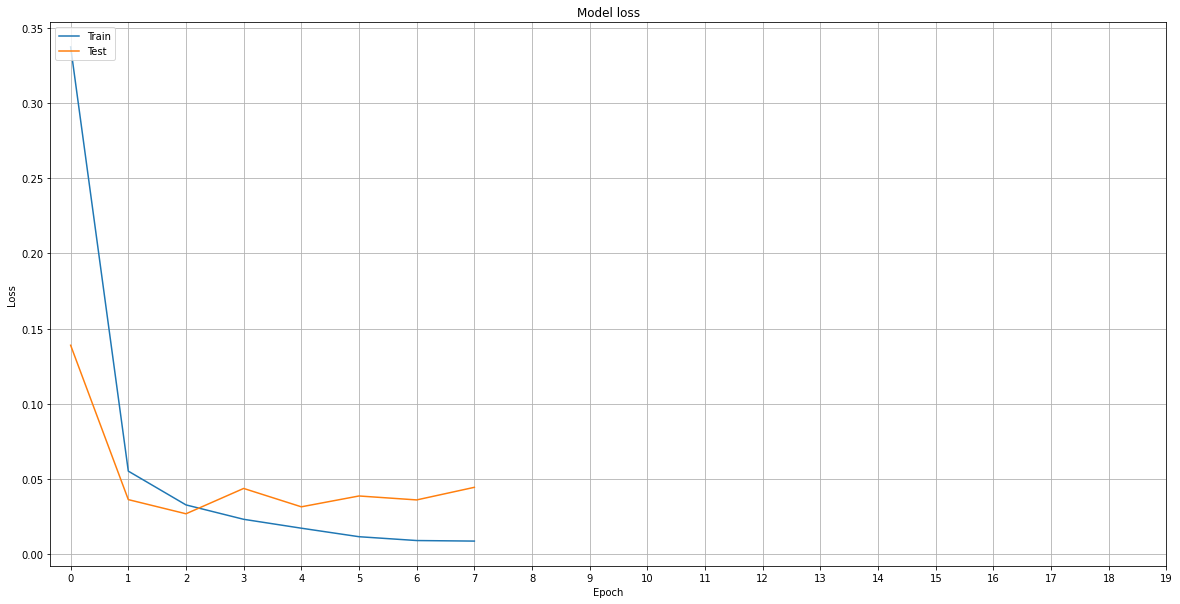

In [11]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"]) 
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(20))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [12]:
MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])

# Add results to dictionary
results_dict['{}_{}dayshift_MAE'.format(ticker, shift)] = MAE_list
results_dict['{}_{}dayshift_MAPE'.format(ticker, shift)] = MAPE_list
results_dict['{}_{}dayshift_MDAPE'.format(ticker, shift)] = MDAPE_list
results

Median Absolute Error (MAE): 98.69
Mean Absolute Percentage Error (MAPE): 2.86 %
Median Absolute Percentage Error (MDAPE): 3.04 %


,MAE,MAPE,MDAPE
0,98.692607,2.862376,3.041094


In [13]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Close"], True)
valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

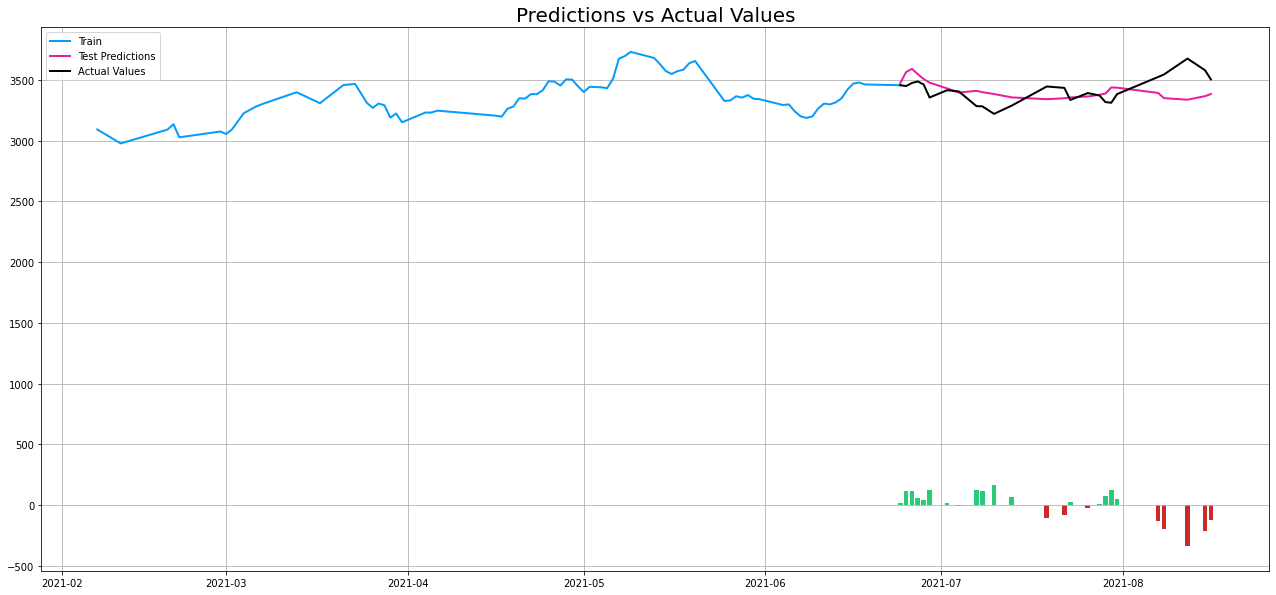

In [14]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

### 4-Day Shift

In [15]:
## DAILY%CHANGE ##
dep_var = ['Close'] 
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 4

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)

pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['High', 'Low', '3Dir', '4D%Change', '6D%Change', 'Open', '7D%Change', 'SD', 'SD_log', 'Volume', '6Dir', 'Dir', '4Dir', '5D%Change', '7Dir', '2D%Change', '5Dir', '2Dir', 'Daily%Change', '3D%Change']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Close,day_of_week,comments_neutral(t-4),comments_positive(t-4),comment_count(t-4),pct_pos_comments(t-4),comments_neutral_rollsum_2D(t-4),comments_neutral_rollmean_2D(t-4),comments_neutral_2D_pctchg(t-4),comments_positive_rollsum_2D(t-4),...,Dir(t-4),4Dir(t-4),5D%Change(t-4),7Dir(t-4),2D%Change(t-4),5Dir(t-4),2Dir(t-4),Daily%Change(t-4),3D%Change(t-4),Close(t-4)
10,3120.760010,1,8.0,4.0,12.0,33.333056,11.0,5.5,166.666667,9.0,...,1.0,0.0,-3.034943,0.0,-1.943943,0.0,0.0,0.212578,-1.307013,3120.830078
11,3263.379883,2,7.0,6.0,13.0,46.153491,15.0,7.5,133.333333,10.0,...,1.0,1.0,0.876567,0.0,1.659488,1.0,1.0,1.443841,-0.528170,3165.889893
12,3306.989990,3,2.0,2.0,4.0,49.998750,9.0,4.5,-75.000000,8.0,...,0.0,0.0,-1.097033,0.0,0.212760,0.0,1.0,-1.213558,0.425790,3127.469971
13,3292.229980,4,3.0,1.0,4.0,24.999375,5.0,2.5,-57.142857,3.0,...,0.0,0.0,-2.464887,0.0,-1.947001,0.0,0.0,-0.742452,-0.531271,3104.250000
14,3294.000000,0,80.0,13.0,93.0,13.978480,194.0,97.0,1500.000000,30.0,...,1.0,0.0,0.210328,0.0,-0.214549,1.0,0.0,0.531852,-1.425504,3120.760010


In [16]:
# List of considered Features
FEATURES = pred_lag.columns

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext[dep_var[0]]

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['Close', 'day_of_week', 'comments_neutral(t-4)', 'comments_positive(t-4)', 'comment_count(t-4)', 'pct_pos_comments(t-4)', 'comments_neutral_rollsum_2D(t-4)', 'comments_neutral_rollmean_2D(t-4)', 'comments_neutral_2D_pctchg(t-4)', 'comments_positive_rollsum_2D(t-4)', 'comments_positive_rollmean_2D(t-4)', 'comments_positive_2D_pctchg(t-4)', 'comment_count_rollsum_2D(t-4)', 'comment_count_rollmean_2D(t-4)', 'comment_count_2D_pctchg(t-4)', 'pct_pos_comments_rollsum_2D(t-4)', 'pct_pos_comments_rollmean_2D(t-4)', 'pct_pos_comments_2D_pctchg(t-4)', 'comments_neutral_rollsum_3D(t-4)', 'comments_neutral_rollmean_3D(t-4)', 'comments_neutral_3D_pctchg(t-4)', 'comments_positive_rollsum_3D(t-4)', 'comments_positive_rollmean_3D(t-4)', 'comments_positive_3D_pctchg(t-4)', 'comment_count_rollsum_3D(t-4)', 'comment_count_rollmean_3D(t-4)', 'comment_count_3D_pctchg(t-4)', 'pct_pos_comments_rollsum_3D(t-4)', 'pct_pos_comments_rollmean_3D(t-4)', 'pct_pos_comments_3D_pctchg(t-4)', 'comments_ne

,Close,day_of_week,comments_neutral(t-4),comments_positive(t-4),comment_count(t-4),pct_pos_comments(t-4),comments_neutral_rollsum_2D(t-4),comments_neutral_rollmean_2D(t-4),comments_neutral_2D_pctchg(t-4),comments_positive_rollsum_2D(t-4),...,4Dir(t-4),5D%Change(t-4),7Dir(t-4),2D%Change(t-4),5Dir(t-4),2Dir(t-4),Daily%Change(t-4),3D%Change(t-4),Close(t-4),Prediction
222,3696.060059,3,1.0,1.0,2.0,49.997500,3.0,1.5,0.000000,1.0,...,1.0,0.175048,1.0,1.237772,1.0,1.0,1.516196,-1.428322,3525.149902,3696.060059
224,3572.570068,0,2.0,1.0,3.0,33.332222,3.0,1.5,100.000000,1.0,...,1.0,-0.993505,1.0,0.441117,0.0,1.0,-0.140452,1.964001,3540.699951,3572.570068
226,3580.409912,2,4.0,1.0,5.0,19.999600,5.0,2.5,100.000000,1.0,...,1.0,6.438015,1.0,4.387836,1.0,1.0,4.143704,4.241221,3696.060059,3580.409912
228,3561.570068,0,4.0,3.0,7.0,42.856531,67.0,33.5,-89.189189,20.0,...,1.0,0.758392,1.0,-3.341125,1.0,0.0,-2.828723,0.664133,3572.570068,3561.570068
230,3443.719971,2,1.0,1.0,2.0,49.997500,2.0,1.0,-75.000000,1.0,...,0.0,0.885036,1.0,0.219445,1.0,1.0,0.010332,-2.615485,3580.409912,3443.719971


In [17]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc(dep_var[0])

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data first
train_data = data_filtered.iloc[0:train_data_len]
test_data = data_filtered.iloc[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)


# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext[dep_var[0]][0:train_data_len])
np_Close_scaled = scaler_pred.fit_transform(df_Close)


(97, 100)
(31, 100)


In [18]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(90, 7, 100) (90,)
(24, 7, 100) (24,)
0.25242888389360996
0.25242888389360996


In [19]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

700 7 100


In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = '{}_{}_{}shift_Sentiment.h5'.format(ticker, dep_var[0], shift)
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
6/6 [==============================] - ETA: 0s - loss: 0.7958
Epoch 1: val_loss improved from inf to 0.18634, saving model to AMZN_Close_4shift_Sentiment.h5
6/6 [==============================] - 8s 727ms/step - loss: 0.7958 - val_loss: 0.1863
Epoch 2/100
6/6 [==============================] - ETA: 0s - loss: 0.0685
Epoch 2: val_loss improved from 0.18634 to 0.04265, saving model to AMZN_Close_4shift_Sentiment.h5
6/6 [==============================] - 2s 344ms/step - loss: 0.0685 - val_loss: 0.0427
Epoch 3/100
6/6 [==============================] - ETA: 0s - loss: 0.0547
Epoch 3: val_loss did not improve from 0.04265
6/6 [==============================] - 2s 279ms/step - loss: 0.0547 - val_loss: 0.0568
Epoch 4/100
6/6 [==============================] - ETA: 0s - loss: 0.0413
Epoch 4: val_loss did not improve from 0.04265
6/6 [==============================] - 2s 279ms/step - loss: 0.0413 - val_loss: 0.0501
Epoch 5/100
6/6 [==============================] - ETA: 0s - loss: 0

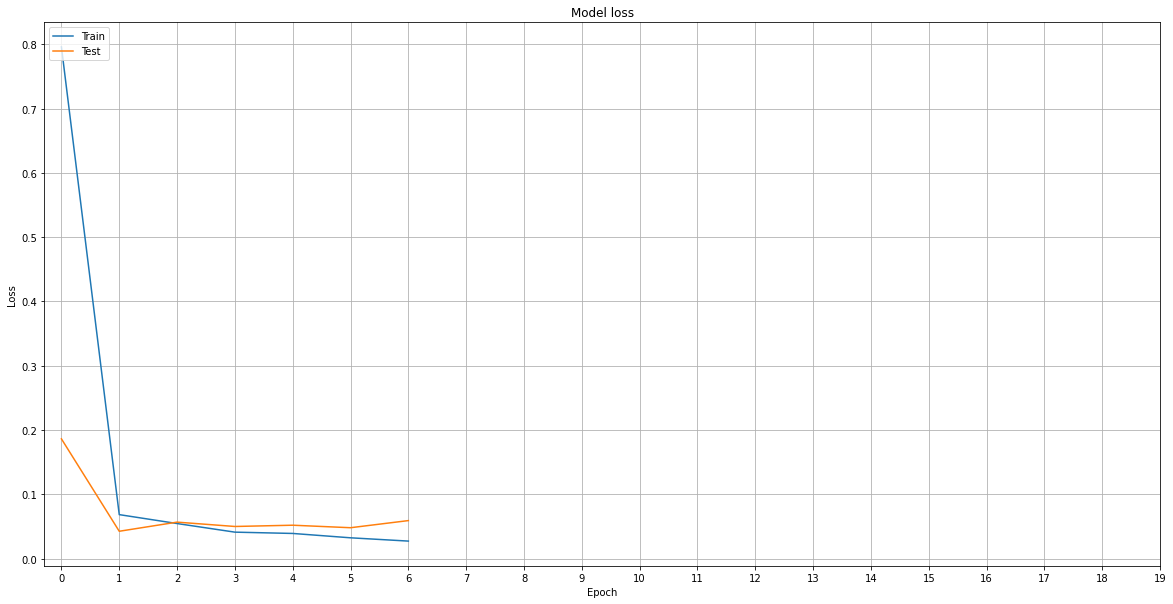

In [21]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"]) 
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(20))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [22]:
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model

MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])

# Add results to dictionary
results_dict['{}_{}dayshift_MAE'.format(ticker, shift)] = MAE_list
results_dict['{}_{}dayshift_MAPE'.format(ticker, shift)] = MAPE_list
results_dict['{}_{}dayshift_MDAPE'.format(ticker, shift)] = MDAPE_list

results

Median Absolute Error (MAE): 108.04
Mean Absolute Percentage Error (MAPE): 3.1 %
Median Absolute Percentage Error (MDAPE): 3.11 %


,MAE,MAPE,MDAPE
0,108.039805,3.095004,3.108908


In [23]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Close"], True)
valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

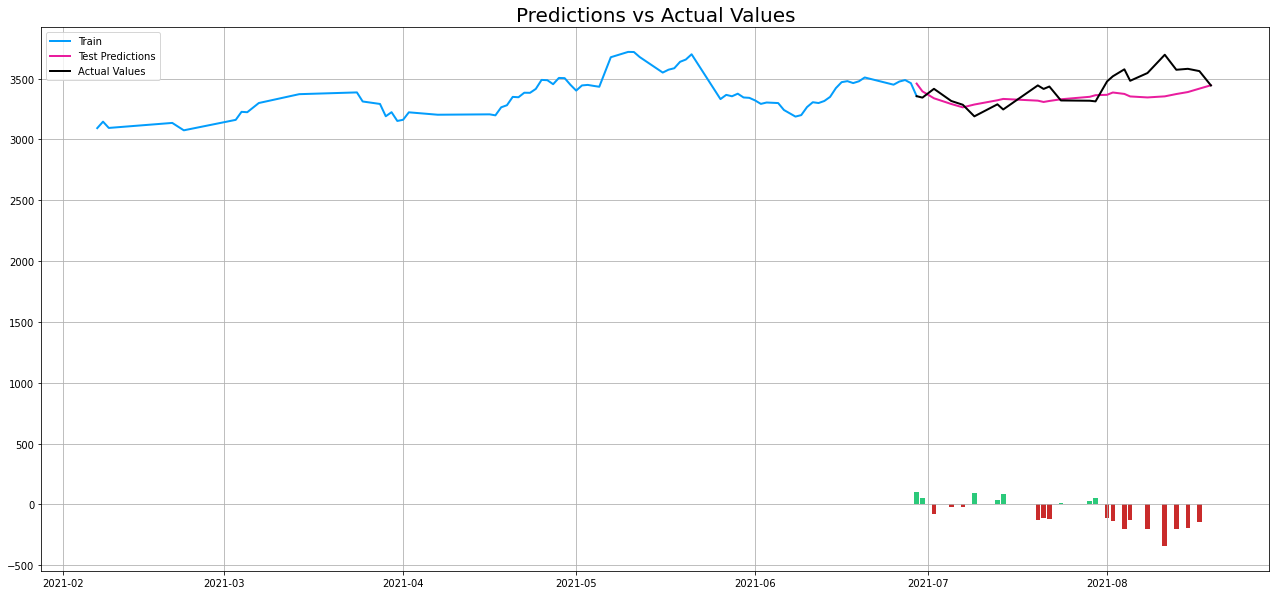

In [24]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

### 7-Day Shift

In [25]:
## DAILY%CHANGE ##
dep_var = ['Close'] 
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 7

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)

pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['High', 'Low', '3Dir', '4D%Change', '6D%Change', 'Open', '7D%Change', 'SD', 'SD_log', 'Volume', '6Dir', 'Dir', '4Dir', '5D%Change', '7Dir', '2D%Change', '5Dir', '2Dir', 'Daily%Change', '3D%Change']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Close,day_of_week,comments_neutral(t-7),comments_positive(t-7),comment_count(t-7),pct_pos_comments(t-7),comments_neutral_rollsum_2D(t-7),comments_neutral_rollmean_2D(t-7),comments_neutral_2D_pctchg(t-7),comments_positive_rollsum_2D(t-7),...,Dir(t-7),4Dir(t-7),5D%Change(t-7),7Dir(t-7),2D%Change(t-7),5Dir(t-7),2Dir(t-7),Daily%Change(t-7),3D%Change(t-7),Close(t-7)
13,3292.229980,4,8.0,4.0,12.0,33.333056,11.0,5.5,166.666667,9.0,...,1.0,0.0,-3.034943,0.0,-1.943943,0.0,0.0,0.212578,-1.307013,3120.830078
14,3294.000000,0,3.0,1.0,4.0,24.999375,5.0,2.5,-57.142857,3.0,...,1.0,1.0,0.876567,0.0,1.659488,1.0,1.0,1.443841,-0.528170,3165.889893
15,3326.129883,1,5.0,5.0,10.0,49.999500,8.0,4.0,150.000000,6.0,...,0.0,0.0,-1.097033,0.0,0.212760,0.0,1.0,-1.213558,0.425790,3127.469971
16,3232.580078,2,114.0,17.0,131.0,12.977089,119.0,59.5,3700.000000,22.0,...,0.0,0.0,-2.464887,0.0,-1.947001,0.0,0.0,-0.742452,-0.531271,3104.250000
17,3237.620117,3,80.0,13.0,93.0,13.978480,194.0,97.0,1500.000000,30.0,...,1.0,0.0,0.210328,0.0,-0.214549,1.0,0.0,0.531852,-1.425504,3120.760010


In [26]:
# List of considered Features
FEATURES = pred_lag.columns

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext[dep_var[0]]

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['Close', 'day_of_week', 'comments_neutral(t-7)', 'comments_positive(t-7)', 'comment_count(t-7)', 'pct_pos_comments(t-7)', 'comments_neutral_rollsum_2D(t-7)', 'comments_neutral_rollmean_2D(t-7)', 'comments_neutral_2D_pctchg(t-7)', 'comments_positive_rollsum_2D(t-7)', 'comments_positive_rollmean_2D(t-7)', 'comments_positive_2D_pctchg(t-7)', 'comment_count_rollsum_2D(t-7)', 'comment_count_rollmean_2D(t-7)', 'comment_count_2D_pctchg(t-7)', 'pct_pos_comments_rollsum_2D(t-7)', 'pct_pos_comments_rollmean_2D(t-7)', 'pct_pos_comments_2D_pctchg(t-7)', 'comments_neutral_rollsum_3D(t-7)', 'comments_neutral_rollmean_3D(t-7)', 'comments_neutral_3D_pctchg(t-7)', 'comments_positive_rollsum_3D(t-7)', 'comments_positive_rollmean_3D(t-7)', 'comments_positive_3D_pctchg(t-7)', 'comment_count_rollsum_3D(t-7)', 'comment_count_rollmean_3D(t-7)', 'comment_count_3D_pctchg(t-7)', 'pct_pos_comments_rollsum_3D(t-7)', 'pct_pos_comments_rollmean_3D(t-7)', 'pct_pos_comments_3D_pctchg(t-7)', 'comments_ne

,Close,day_of_week,comments_neutral(t-7),comments_positive(t-7),comment_count(t-7),pct_pos_comments(t-7),comments_neutral_rollsum_2D(t-7),comments_neutral_rollmean_2D(t-7),comments_neutral_2D_pctchg(t-7),comments_positive_rollsum_2D(t-7),...,4Dir(t-7),5D%Change(t-7),7Dir(t-7),2D%Change(t-7),5Dir(t-7),2Dir(t-7),Daily%Change(t-7),3D%Change(t-7),Close(t-7),Prediction
218,3525.149902,4,8.0,4.0,12.0,33.333056,8.0,4.0,100.000000,4.0,...,0.0,-0.250258,1.0,1.985766,0.0,1.0,2.150781,0.343078,3384.000000,3525.149902
222,3696.060059,3,12.0,3.0,15.0,19.999867,16.0,8.0,100.000000,3.0,...,1.0,7.953512,1.0,1.626603,1.0,1.0,2.500731,2.853896,3576.229980,3696.060059
229,3507.070068,1,37.0,5.0,42.0,11.904734,38.0,19.0,100.000000,5.0,...,1.0,6.438015,1.0,4.387836,1.0,1.0,4.143704,4.241221,3696.060059,3507.070068
230,3443.719971,2,63.0,17.0,80.0,21.249973,100.0,50.0,6200.000000,22.0,...,1.0,4.295425,1.0,3.594536,1.0,1.0,-0.527318,3.837380,3676.570068,3443.719971
231,3437.360107,3,4.0,3.0,7.0,42.856531,67.0,33.5,-89.189189,20.0,...,1.0,0.758392,1.0,-3.341125,1.0,0.0,-2.828723,0.664133,3572.570068,3437.360107


In [27]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc(dep_var[0])

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data first
train_data = data_filtered.iloc[0:train_data_len]
test_data = data_filtered.iloc[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)


# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext[dep_var[0]][0:train_data_len])
np_Close_scaled = scaler_pred.fit_transform(df_Close)


(106, 100)
(33, 100)


In [28]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(99, 7, 100) (99,)
(26, 7, 100) (26,)
0.44433836141007266
0.44433836141007266


In [29]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

700 7 100


In [30]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = '{}_{}_{}shift_Sentiment.h5'.format(ticker, dep_var[0], shift)
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
7/7 [==============================] - ETA: 0s - loss: 0.8888
Epoch 1: val_loss improved from inf to 0.05878, saving model to AMZN_Close_7shift_Sentiment.h5
7/7 [==============================] - 8s 662ms/step - loss: 0.8888 - val_loss: 0.0588
Epoch 2/100
7/7 [==============================] - ETA: 0s - loss: 0.0674
Epoch 2: val_loss did not improve from 0.05878
7/7 [==============================] - 2s 297ms/step - loss: 0.0674 - val_loss: 0.0858
Epoch 3/100
7/7 [==============================] - ETA: 0s - loss: 0.0615
Epoch 3: val_loss improved from 0.05878 to 0.04870, saving model to AMZN_Close_7shift_Sentiment.h5
7/7 [==============================] - 2s 333ms/step - loss: 0.0615 - val_loss: 0.0487
Epoch 4/100
7/7 [==============================] - ETA: 0s - loss: 0.0376
Epoch 4: val_loss improved from 0.04870 to 0.04567, saving model to AMZN_Close_7shift_Sentiment.h5
7/7 [==============================] - 2s 334ms/step - loss: 0.0376 - val_loss: 0.0457
Epoch 5/100
7/7 

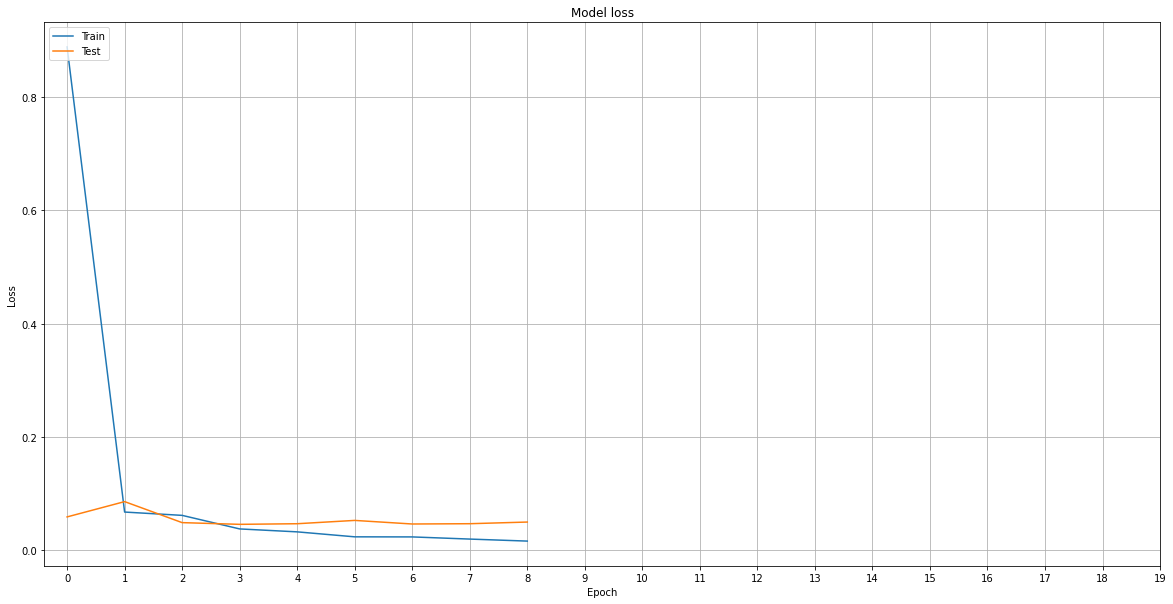

In [31]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"]) 
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(20))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [32]:
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model

MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])

# Add results to dictionary
results_dict['{}_{}dayshift_MAE'.format(ticker, shift)] = MAE_list
results_dict['{}_{}dayshift_MAPE'.format(ticker, shift)] = MAPE_list
results_dict['{}_{}dayshift_MDAPE'.format(ticker, shift)] = MDAPE_list

results

Median Absolute Error (MAE): 127.15
Mean Absolute Percentage Error (MAPE): 3.66 %
Median Absolute Percentage Error (MDAPE): 3.05 %


,MAE,MAPE,MDAPE
0,127.145714,3.656097,3.045341


In [33]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Close"], True)
valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

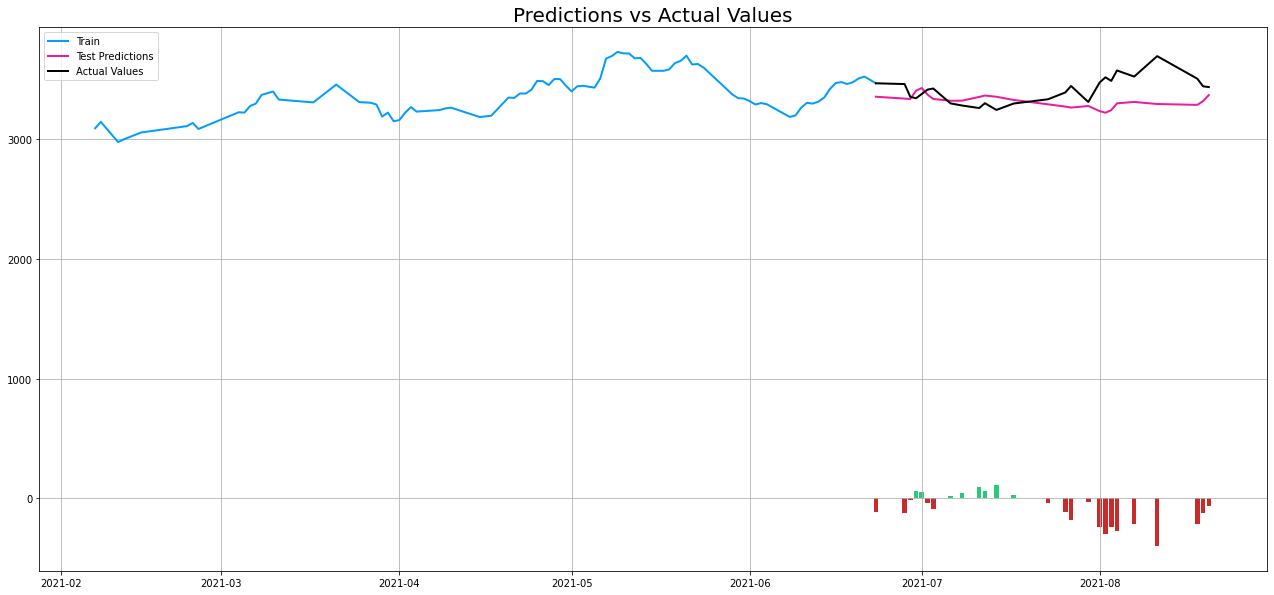

In [34]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

## LSTM: CLOSE PRICE WITHOUT SENTIMENT

### 1-Day Shift

In [35]:
dep_var = ['Close'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 1

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)

to_drop = [i for i in pred_lag.columns if 'pos' in i] + [i for i in pred_lag.columns if 'neu' in i]
pred_lag = pred_lag.drop(to_drop, axis = 1)

pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['High', 'Low', '3Dir', '4D%Change', '6D%Change', 'Open', '7D%Change', 'SD', 'SD_log', 'Volume', '6Dir', 'Dir', '4Dir', '5D%Change', '7Dir', '2D%Change', '5Dir', '2Dir', 'Daily%Change', '3D%Change']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Close,day_of_week,comment_count(t-1),comment_count_rollsum_2D(t-1),comment_count_rollmean_2D(t-1),comment_count_2D_pctchg(t-1),comment_count_rollsum_3D(t-1),comment_count_rollmean_3D(t-1),comment_count_3D_pctchg(t-1),comment_count_rollsum_4D(t-1),...,Dir(t-1),4Dir(t-1),5D%Change(t-1),7Dir(t-1),2D%Change(t-1),5Dir(t-1),2Dir(t-1),Daily%Change(t-1),3D%Change(t-1),Close(t-1)
7,3165.889893,2,5.0,11.0,5.5,-58.333333,23.0,7.666667,150.000000,25.0,...,1.0,0.0,-3.034943,0.0,-1.943943,0.0,0.0,0.212578,-1.307013,3120.830078
8,3127.469971,3,3.0,8.0,4.0,-50.000000,14.0,4.666667,-75.000000,26.0,...,1.0,1.0,0.876567,0.0,1.659488,1.0,1.0,1.443841,-0.528170,3165.889893
9,3104.250000,4,8.0,11.0,5.5,60.000000,16.0,5.333333,33.333333,22.0,...,0.0,0.0,-1.097033,0.0,0.212760,0.0,1.0,-1.213558,0.425790,3127.469971
10,3120.760010,1,4.0,8.0,4.0,-69.230769,21.0,7.000000,-66.666667,33.0,...,0.0,0.0,-2.464887,0.0,-1.947001,0.0,0.0,-0.742452,-0.531271,3104.250000
11,3263.379883,2,10.0,14.0,7.0,150.000000,18.0,6.000000,-23.076923,31.0,...,1.0,0.0,0.210328,0.0,-0.214549,1.0,0.0,0.531852,-1.425504,3120.760010


In [36]:
# List of considered Features
FEATURES = pred_lag.columns

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext[dep_var]

# Print the tail of the dataframe
data_filtered_ext.tail()

,Close,day_of_week,comment_count(t-1),comment_count_rollsum_2D(t-1),comment_count_rollmean_2D(t-1),comment_count_2D_pctchg(t-1),comment_count_rollsum_3D(t-1),comment_count_rollmean_3D(t-1),comment_count_3D_pctchg(t-1),comment_count_rollsum_4D(t-1),...,4Dir(t-1),5D%Change(t-1),7Dir(t-1),2D%Change(t-1),5Dir(t-1),2Dir(t-1),Daily%Change(t-1),3D%Change(t-1),Close(t-1),Prediction
229,3507.070068,1,4.0,4.0,2.0,100.0,6.0,2.000000,300.0,7.0,...,0.0,-3.127915,1.0,-0.526192,0.0,0.0,1.626738,-0.515915,3561.570068,3507.070068
234,3523.290039,1,1.0,1.0,0.5,0.0,2.0,0.666667,100.0,2.0,...,0.0,-3.768000,0.0,-0.290630,0.0,0.0,1.108626,-0.474773,3427.370117,3523.290039
236,3483.419922,3,1.0,1.0,0.5,0.0,2.0,0.666667,100.0,2.0,...,1.0,2.306806,0.0,2.794848,1.0,1.0,-0.003693,3.934458,3523.159912,3483.419922
237,3444.239990,4,4.0,5.0,2.5,100.0,5.0,1.666667,300.0,6.0,...,1.0,1.339976,0.0,-1.131616,1.0,0.0,-1.127964,1.635359,3483.419922,3444.239990
241,3377.419922,3,1.0,1.0,0.5,100.0,1.0,0.333333,100.0,1.0,...,0.0,-1.613888,1.0,2.210033,0.0,1.0,2.497759,0.640491,3466.300049,3377.419922


In [37]:
import math
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc(dep_var[0])

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data
train_data = data_filtered[0:train_data_len]
test_data = data_filtered[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)

# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext[dep_var])
np_Close_scaled = scaler_pred.fit_transform(df_Close)


(159, 43)
(46, 43)


In [38]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(152, 7, 43) (152,)
(39, 7, 43) (39,)
0.4197575045470332
0.4197575045470332


In [39]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

301 7 43


In [40]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = '{}_{}_{}shift_Baseline.h5'.format(ticker, dep_var[0], shift)
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 0.1187
Epoch 1: val_loss improved from inf to 0.02600, saving model to AMZN_Close_1shift_Baseline.h5
10/10 [==============================] - 5s 177ms/step - loss: 0.1187 - val_loss: 0.0260
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 0.0244
Epoch 2: val_loss improved from 0.02600 to 0.02145, saving model to AMZN_Close_1shift_Baseline.h5
10/10 [==============================] - 1s 83ms/step - loss: 0.0244 - val_loss: 0.0215
Epoch 3/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.0165
Epoch 3: val_loss did not improve from 0.02145
10/10 [==============================] - 1s 69ms/step - loss: 0.0166 - val_loss: 0.0242
Epoch 4/100
10/10 [==============================] - ETA: 0s - loss: 0.0128
Epoch 4: val_loss improved from 0.02145 to 0.01765, saving model to AMZN_Close_1shift_Baseline.h5
10/10 [==============================] - 1s 79ms/step - loss: 0.0128 - val_loss: 0.0177
Epoch 

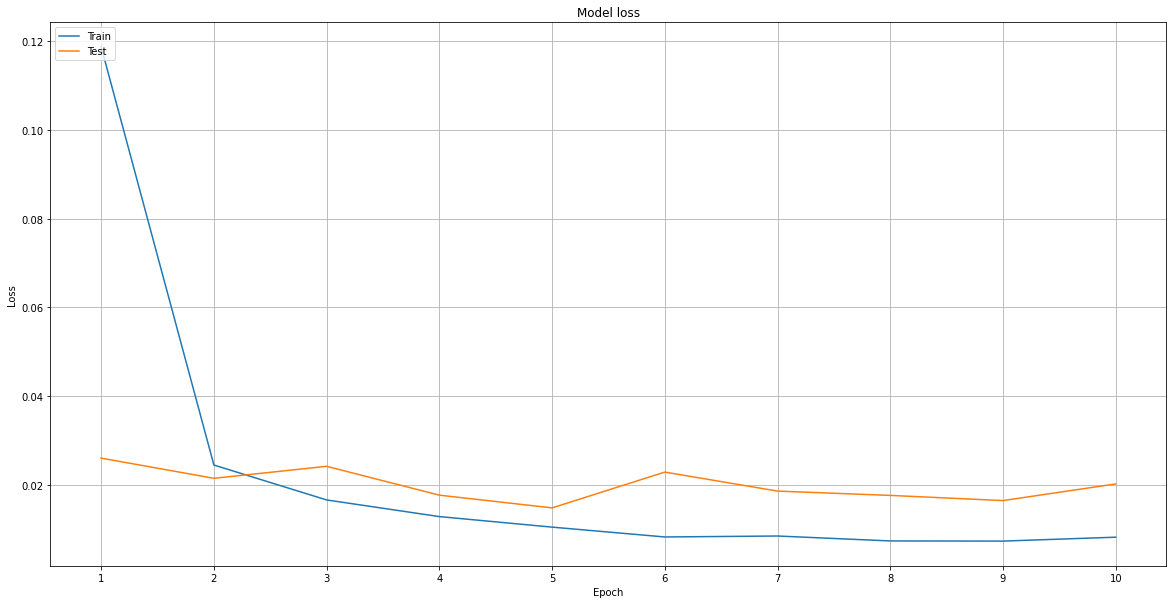

In [41]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(10), np.arange(1, 11))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [42]:
MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])

# Add results to dictionary
results_dict['{}_{}dayshift_MAE_baseline'.format(ticker, shift)] = MAE_list
results_dict['{}_{}dayshift_MAPE_baseline'.format(ticker, shift)] = MAPE_list
results_dict['{}_{}dayshift_MDAPE_baseline'.format(ticker, shift)] = MDAPE_list


results

Median Absolute Error (MAE): 74.59
Mean Absolute Percentage Error (MAPE): 2.17 %
Median Absolute Percentage Error (MDAPE): 1.88 %


,MAE,MAPE,MDAPE
0,74.594514,2.174031,1.87522


In [43]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid[dep_var[0]], True)

valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

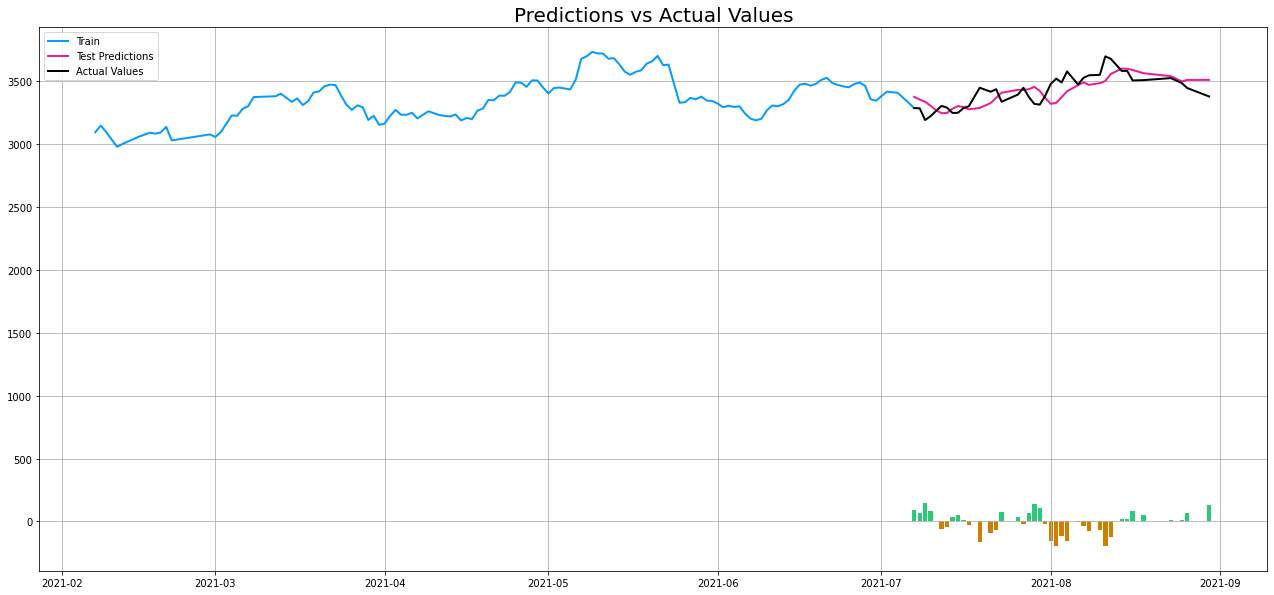

In [44]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[dep_var]
xv = valid['Date']; yv = valid[[dep_var[0], "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv[dep_var[0]], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A" #green gain
valid.loc[y < 0, 'diff_color'] = "#ce7e00" #brown loss

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

### 4-Day Shift

In [45]:
dep_var = ['Close'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 4

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)

to_drop = [i for i in pred_lag.columns if 'pos' in i] + [i for i in pred_lag.columns if 'neu' in i]
pred_lag = pred_lag.drop(to_drop, axis = 1)

pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['High', 'Low', '3Dir', '4D%Change', '6D%Change', 'Open', '7D%Change', 'SD', 'SD_log', 'Volume', '6Dir', 'Dir', '4Dir', '5D%Change', '7Dir', '2D%Change', '5Dir', '2Dir', 'Daily%Change', '3D%Change']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Close,day_of_week,comment_count(t-4),comment_count_rollsum_2D(t-4),comment_count_rollmean_2D(t-4),comment_count_2D_pctchg(t-4),comment_count_rollsum_3D(t-4),comment_count_rollmean_3D(t-4),comment_count_3D_pctchg(t-4),comment_count_rollsum_4D(t-4),...,Dir(t-4),4Dir(t-4),5D%Change(t-4),7Dir(t-4),2D%Change(t-4),5Dir(t-4),2Dir(t-4),Daily%Change(t-4),3D%Change(t-4),Close(t-4)
10,3120.760010,1,12.0,20.0,10.0,300.000000,23.0,7.666667,140.000000,28.0,...,1.0,0.0,-3.034943,0.0,-1.943943,0.0,0.0,0.212578,-1.307013,3120.830078
11,3263.379883,2,13.0,25.0,12.5,62.500000,33.0,11.000000,333.333333,36.0,...,1.0,1.0,0.876567,0.0,1.659488,1.0,1.0,1.443841,-0.528170,3165.889893
12,3306.989990,3,4.0,17.0,8.5,-66.666667,29.0,9.666667,-50.000000,37.0,...,0.0,0.0,-1.097033,0.0,0.212760,0.0,1.0,-1.213558,0.425790,3127.469971
13,3292.229980,4,4.0,8.0,4.0,-69.230769,21.0,7.000000,-66.666667,33.0,...,0.0,0.0,-2.464887,0.0,-1.947001,0.0,0.0,-0.742452,-0.531271,3104.250000
14,3294.000000,0,93.0,224.0,112.0,830.000000,234.0,78.000000,2225.000000,238.0,...,1.0,0.0,0.210328,0.0,-0.214549,1.0,0.0,0.531852,-1.425504,3120.760010


In [46]:
# List of considered Features
FEATURES = pred_lag.columns

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext[dep_var]

# Print the tail of the dataframe
data_filtered_ext.tail()

,Close,day_of_week,comment_count(t-4),comment_count_rollsum_2D(t-4),comment_count_rollmean_2D(t-4),comment_count_2D_pctchg(t-4),comment_count_rollsum_3D(t-4),comment_count_rollmean_3D(t-4),comment_count_3D_pctchg(t-4),comment_count_rollsum_4D(t-4),...,4Dir(t-4),5D%Change(t-4),7Dir(t-4),2D%Change(t-4),5Dir(t-4),2Dir(t-4),Daily%Change(t-4),3D%Change(t-4),Close(t-4),Prediction
232,3389.790039,4,4.0,4.0,2.0,100.0,6.0,2.000000,300.0,7.0,...,0.0,-3.127915,1.0,-0.526192,0.0,0.0,1.626738,-0.515915,3561.570068,3389.790039
235,3523.159912,2,1.0,1.0,0.5,100.0,1.0,0.333333,100.0,1.0,...,0.0,-3.995347,0.0,-1.987698,0.0,0.0,-0.184680,-3.487506,3437.360107,3523.159912
237,3444.239990,4,1.0,1.0,0.5,0.0,2.0,0.666667,100.0,2.0,...,0.0,-3.768000,0.0,-0.290630,0.0,0.0,1.108626,-0.474773,3427.370117,3444.239990
238,3391.350098,0,4.0,5.0,2.5,100.0,5.0,1.666667,300.0,6.0,...,1.0,0.462493,1.0,3.938297,1.0,1.0,2.798645,2.499882,3523.290039,3391.350098
239,3381.830078,1,4.0,8.0,4.0,300.0,9.0,3.000000,100.0,9.0,...,1.0,2.306806,0.0,2.794848,1.0,1.0,-0.003693,3.934458,3523.159912,3381.830078


In [47]:
import math
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc(dep_var[0])

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data
train_data = data_filtered[0:train_data_len]
test_data = data_filtered[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)

# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext[dep_var])
np_Close_scaled = scaler_pred.fit_transform(df_Close)


(156, 43)
(46, 43)


In [48]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(149, 7, 43) (149,)
(39, 7, 43) (39,)
0.3664975500114638
0.3664975500114638


In [49]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

301 7 43


In [50]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = '{}_{}_{}shift_Baseline.h5'.format(ticker, dep_var[0], shift)
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 0.1468
Epoch 1: val_loss improved from inf to 0.01377, saving model to AMZN_Close_4shift_Baseline.h5
10/10 [==============================] - 5s 181ms/step - loss: 0.1468 - val_loss: 0.0138
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 0.0285
Epoch 2: val_loss did not improve from 0.01377
10/10 [==============================] - 1s 72ms/step - loss: 0.0285 - val_loss: 0.0291
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 0.0233
Epoch 3: val_loss did not improve from 0.01377
10/10 [==============================] - 1s 71ms/step - loss: 0.0233 - val_loss: 0.0146
Epoch 4/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.0170
Epoch 4: val_loss did not improve from 0.01377
10/10 [==============================] - 1s 69ms/step - loss: 0.0172 - val_loss: 0.0187
Epoch 5/100
10/10 [==============================] - ETA: 0s - loss: 0.0156
Epoch 5: val_loss did not improv

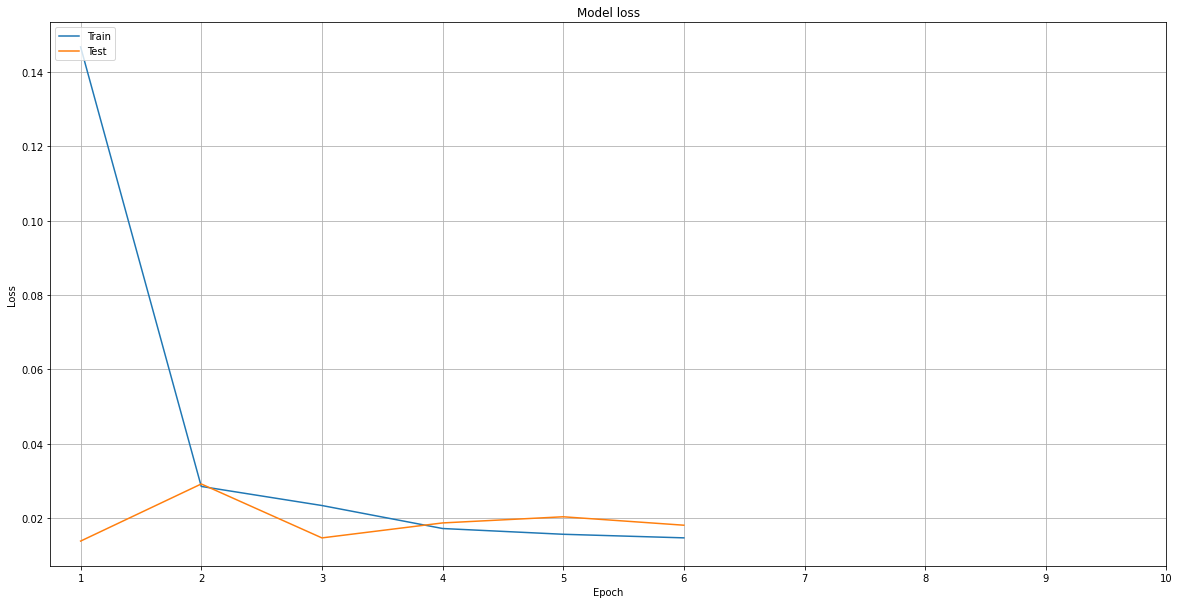

In [51]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(10), np.arange(1, 11))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [52]:
MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])

# Add results to dictionary
results_dict['{}_{}dayshift_MAE_baseline'.format(ticker, shift)] = MAE_list
results_dict['{}_{}dayshift_MAPE_baseline'.format(ticker, shift)] = MAPE_list
results_dict['{}_{}dayshift_MDAPE_baseline'.format(ticker, shift)] = MDAPE_list


results

Median Absolute Error (MAE): 78.59
Mean Absolute Percentage Error (MAPE): 2.29 %
Median Absolute Percentage Error (MDAPE): 1.98 %


,MAE,MAPE,MDAPE
0,78.589863,2.292549,1.980433


In [53]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid[dep_var[0]], True)

valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

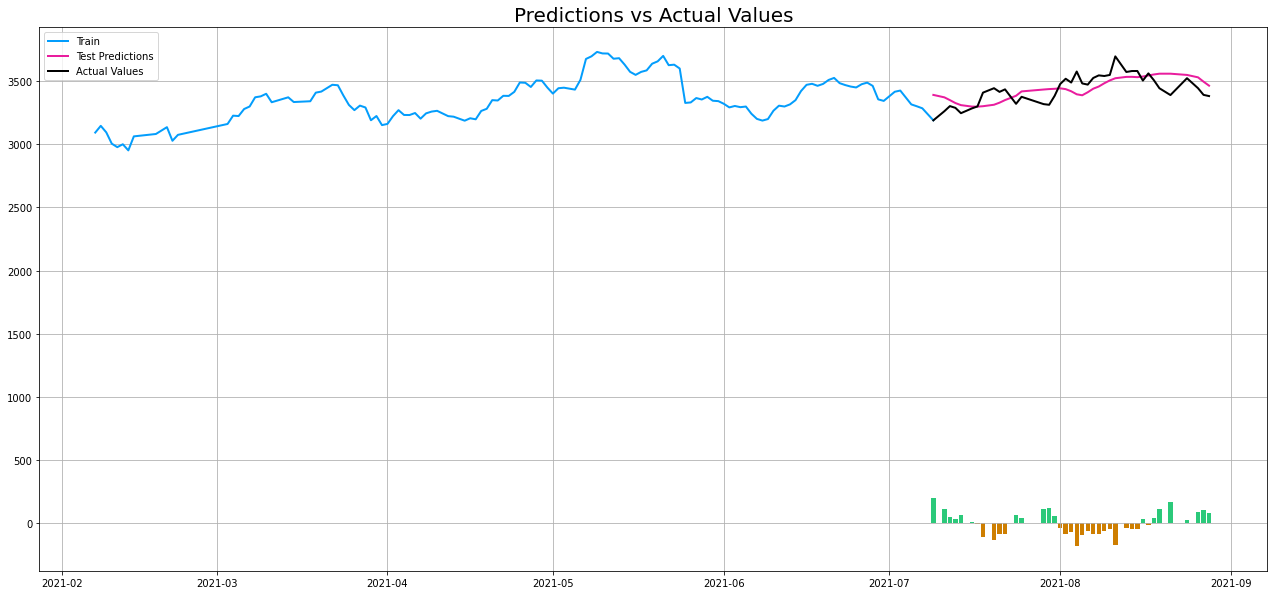

In [54]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[dep_var]
xv = valid['Date']; yv = valid[[dep_var[0], "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv[dep_var[0]], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A" #green gain
valid.loc[y < 0, 'diff_color'] = "#ce7e00" #brown loss

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

### 7-Day Shift

In [55]:
bdep_var = ['Close'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 7

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)

to_drop = [i for i in pred_lag.columns if 'pos' in i] + [i for i in pred_lag.columns if 'neu' in i]
pred_lag = pred_lag.drop(to_drop, axis = 1)

pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['High', 'Low', '3Dir', '4D%Change', '6D%Change', 'Open', '7D%Change', 'SD', 'SD_log', 'Volume', '6Dir', 'Dir', '4Dir', '5D%Change', '7Dir', '2D%Change', '5Dir', '2Dir', 'Daily%Change', '3D%Change']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Close,day_of_week,comment_count(t-7),comment_count_rollsum_2D(t-7),comment_count_rollmean_2D(t-7),comment_count_2D_pctchg(t-7),comment_count_rollsum_3D(t-7),comment_count_rollmean_3D(t-7),comment_count_3D_pctchg(t-7),comment_count_rollsum_4D(t-7),...,Dir(t-7),4Dir(t-7),5D%Change(t-7),7Dir(t-7),2D%Change(t-7),5Dir(t-7),2Dir(t-7),Daily%Change(t-7),3D%Change(t-7),Close(t-7)
13,3292.229980,4,12.0,20.0,10.0,300.000000,23.0,7.666667,140.000000,28.0,...,1.0,0.0,-3.034943,0.0,-1.943943,0.0,0.0,0.212578,-1.307013,3120.830078
14,3294.000000,0,4.0,8.0,4.0,-69.230769,21.0,7.000000,-66.666667,33.0,...,1.0,1.0,0.876567,0.0,1.659488,1.0,1.0,1.443841,-0.528170,3165.889893
15,3326.129883,1,10.0,14.0,7.0,150.000000,18.0,6.000000,-23.076923,31.0,...,0.0,0.0,-1.097033,0.0,0.212760,0.0,1.0,-1.213558,0.425790,3127.469971
16,3232.580078,2,131.0,141.0,70.5,3175.000000,145.0,48.333333,3175.000000,149.0,...,0.0,0.0,-2.464887,0.0,-1.947001,0.0,0.0,-0.742452,-0.531271,3104.250000
17,3237.620117,3,93.0,224.0,112.0,830.000000,234.0,78.000000,2225.000000,238.0,...,1.0,0.0,0.210328,0.0,-0.214549,1.0,0.0,0.531852,-1.425504,3120.760010


In [56]:
# List of considered Features
FEATURES = pred_lag.columns

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext[dep_var]

# Print the tail of the dataframe
data_filtered_ext.tail()

,Close,day_of_week,comment_count(t-7),comment_count_rollsum_2D(t-7),comment_count_rollmean_2D(t-7),comment_count_2D_pctchg(t-7),comment_count_rollsum_3D(t-7),comment_count_rollmean_3D(t-7),comment_count_3D_pctchg(t-7),comment_count_rollsum_4D(t-7),...,4Dir(t-7),5D%Change(t-7),7Dir(t-7),2D%Change(t-7),5Dir(t-7),2Dir(t-7),Daily%Change(t-7),3D%Change(t-7),Close(t-7),Prediction
238,3391.350098,0,1.0,1.0,0.5,0.0,2.0,0.666667,100.0,2.0,...,0.0,-3.995347,0.0,-1.987698,0.0,0.0,-0.184680,-3.487506,3437.360107,3391.350098
240,3466.300049,2,1.0,1.0,0.5,0.0,2.0,0.666667,100.0,2.0,...,0.0,-3.768000,0.0,-0.290630,0.0,0.0,1.108626,-0.474773,3427.370117,3466.300049
241,3377.419922,3,4.0,5.0,2.5,100.0,5.0,1.666667,300.0,6.0,...,1.0,0.462493,1.0,3.938297,1.0,1.0,2.798645,2.499882,3523.290039,3377.419922
242,3400.350098,4,4.0,8.0,4.0,300.0,9.0,3.000000,100.0,9.0,...,1.0,2.306806,0.0,2.794848,1.0,1.0,-0.003693,3.934458,3523.159912,3400.350098
245,3420.739990,2,1.0,1.0,0.5,100.0,1.0,0.333333,100.0,1.0,...,0.0,-1.050952,0.0,-2.643087,0.0,0.0,-1.535604,-3.741238,3391.350098,3420.739990


In [57]:
import math
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc(dep_var[0])

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data
train_data = data_filtered[0:train_data_len]
test_data = data_filtered[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)

# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext[dep_var])
np_Close_scaled = scaler_pred.fit_transform(df_Close)


(162, 43)
(47, 43)


In [58]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(155, 7, 43) (155,)
(40, 7, 43) (40,)
0.5491623306901934
0.5491623306901934


In [59]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

301 7 43


In [60]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = '{}_{}_{}shift_Baseline.h5'.format(ticker, dep_var[0], shift)
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 0.0897
Epoch 1: val_loss improved from inf to 0.01635, saving model to AMZN_Close_7shift_Baseline.h5
10/10 [==============================] - 6s 185ms/step - loss: 0.0897 - val_loss: 0.0163
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 0.0321
Epoch 2: val_loss did not improve from 0.01635
10/10 [==============================] - 1s 71ms/step - loss: 0.0321 - val_loss: 0.0258
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 0.0215
Epoch 3: val_loss did not improve from 0.01635
10/10 [==============================] - 1s 72ms/step - loss: 0.0215 - val_loss: 0.0356
Epoch 4/100
10/10 [==============================] - ETA: 0s - loss: 0.0169
Epoch 4: val_loss did not improve from 0.01635
10/10 [==============================] - 1s 74ms/step - loss: 0.0169 - val_loss: 0.0206
Epoch 5/100
10/10 [==============================] - ETA: 0s - loss: 0.0127
Epoch 5: val_loss did not improv

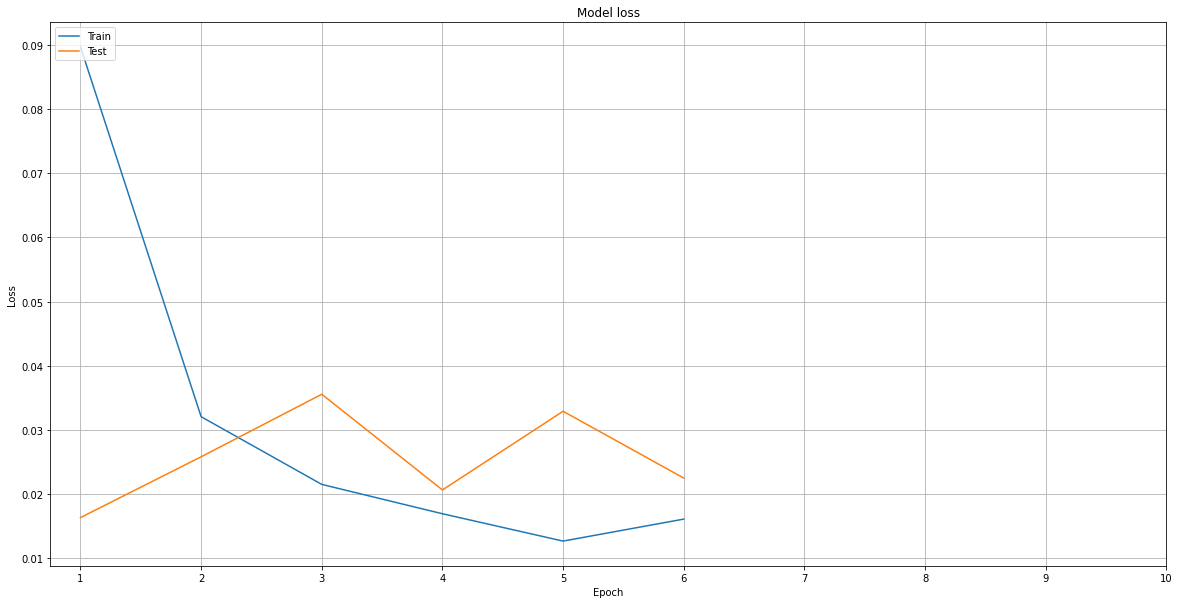

In [61]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(10), np.arange(1, 11))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [62]:
MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])

# Add results to dictionary
results_dict['{}_{}dayshift_MAE_baseline'.format(ticker, shift)] = MAE_list
results_dict['{}_{}dayshift_MAPE_baseline'.format(ticker, shift)] = MAPE_list
results_dict['{}_{}dayshift_MDAPE_baseline'.format(ticker, shift)] = MDAPE_list

results

Median Absolute Error (MAE): 82.48
Mean Absolute Percentage Error (MAPE): 2.4 %
Median Absolute Percentage Error (MDAPE): 2.16 %


,MAE,MAPE,MDAPE
0,82.479224,2.403972,2.161235


In [63]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid[dep_var[0]], True)

valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

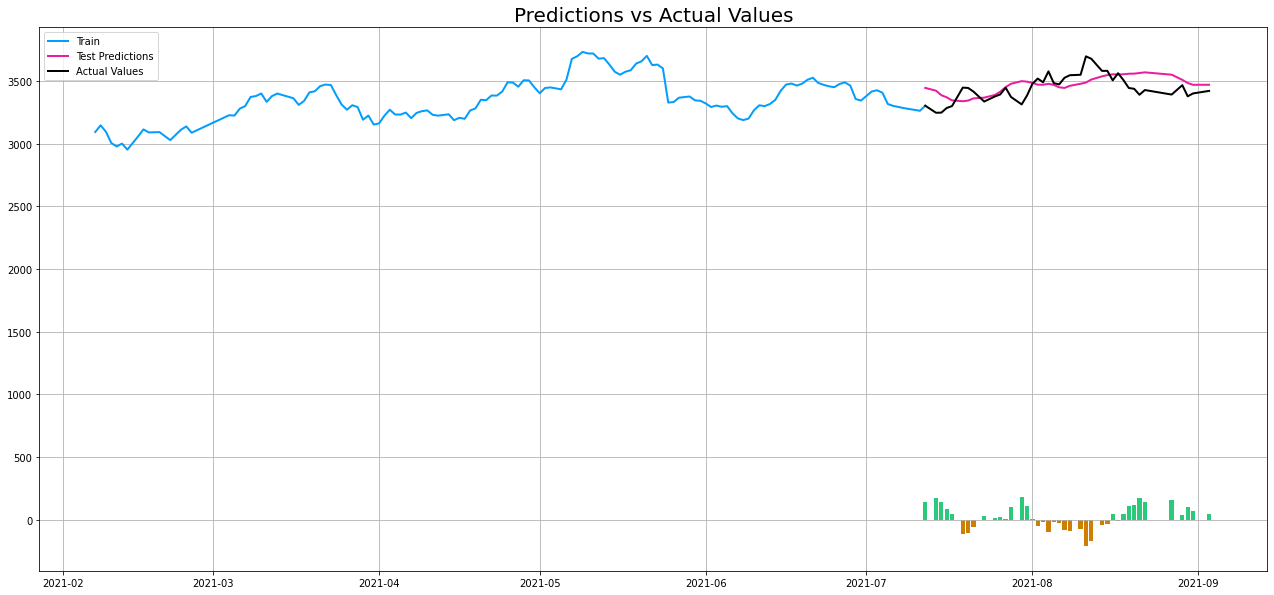

In [64]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[dep_var]
xv = valid['Date']; yv = valid[[dep_var[0], "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv[dep_var[0]], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A" #green gain
valid.loc[y < 0, 'diff_color'] = "#ce7e00" #brown loss

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

## Overall Results

In [65]:
results_df =pd.DataFrame.from_dict(results_dict).transpose().reset_index()
results_df['ticker'] = results_df['index'].str.split('_').str[0]
results_df['shift'] = results_df['index'].str.split('_').str[1]
results_df['metric'] = results_df['index'].str.split('_').str[2]
results_df['scenario'] = results_df['index'].str.split('_').str[3]
results_df['scenario'].fillna(value = 'sentiment', inplace = True)
results_df['results_%'] = results_df[0]
results_df.drop(['index', 0], axis = 1, inplace = True)
results_df.sort_values(['metric', 'shift','scenario'], inplace = True)
results_df = results_df.pivot(index = ['shift', 'metric'], columns = 'scenario', values = 'results_%').reset_index()
results_df

scenario,shift,metric,baseline,sentiment
0,1dayshift,MAE,74.594514,98.692607
1,1dayshift,MAPE,2.174031,2.862376
2,1dayshift,MDAPE,1.875220,3.041094
3,4dayshift,MAE,78.589863,108.039805
4,4dayshift,MAPE,2.292549,3.095004
5,4dayshift,MDAPE,1.980433,3.108908
6,7dayshift,MAE,82.479224,127.145714
7,7dayshift,MAPE,2.403972,3.656097
8,7dayshift,MDAPE,2.161235,3.045341


In [66]:
results_df.to_csv('{}_LSTM.csv'.format(ticker), index = False)